In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/health-data-chatbot/mentalhealth.csv
/kaggle/input/health-data-chatbot/mentalhealth.json


In [2]:
import matplotlib.pyplot as plt
from pathlib import Path
import string
import re 
import joblib
import json
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pickle

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dense, Flatten, Conv1D,MaxPooling1D , SimpleRNN, GRU, LSTM,Input,Embedding,TimeDistributed,Flatten,Dropout,Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
a = nltk.download('punkt')
b= nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
import zipfile

with zipfile.ZipFile('/usr/share/nltk_data/corpora/wordnet.zip') as zip_refs:
    zip_refs.extractall('/usr/share/nltk_data/corpora')
    print('True')

True


In [5]:
with open('/kaggle/input/health-data-chatbot/mentalhealth.json') as file:
    data = json.load(file)
data

{'intents': [{'tag': 'definition',
   'patterns': ['What does it mean to have a mental illness?',
    'What is mental health illness',
    'Describe mental health illness'],
   'responses': ["Mental illnesses are health conditions that disrupt a person's thoughts, emotions, relationships, and daily functioning."],
   'context': ['']},
  {'tag': 'affects_whom',
   'patterns': ['Who does mental illness affect?',
    'Who is affected by mentall illness'],
   'responses': ['It is estimated that mental illness affects 1 in 5 adults in America, and that 1 in 24 adults have a serious mental illness.'],
   'context': ['']},
  {'tag': 'what_causes',
   'patterns': ['What causes mental illness?',
    'What leads to mental illness?',
    'how does one get mentally ill?'],
   'responses': ['Symptoms of mental health disorders vary depending on the type and severity of the condition.'],
   'context': ['']},
  {'tag': 'recover',
   'patterns': ['Can people with mental illness recover?',
    'Is it p

In [6]:
def frame_data(feat_1,feat_2,is_pattern):
    is_pattern = is_pattern
    df = pd.DataFrame(columns=[feat_1,feat_2])
    for intent in data['intents']:
        if is_pattern:
            for pattern in intent['patterns']:
                w = pattern
                df_to_append = pd.Series([w,intent['tag']], index = df.columns)
                df = df.append(df_to_append,ignore_index=True)
        else:
            for response in intent['responses']:
                w = response
                df_to_append = pd.Series([w,intent['tag']], index = df.columns)
                df = df.append(df_to_append,ignore_index=True)
    return df

In [7]:
df1 = frame_data('question','labels',True)
df1.head()

/tmp/ipykernel_931/2056896889.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_to_append,ignore_index=True)
/tmp/ipykernel_931/2056896889.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_to_append,ignore_index=True)
/tmp/ipykernel_931/2056896889.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_to_append,ignore_index=True)
/tmp/ipykernel_931/2056896889.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_to_append,ignore_index=True)
/tmp/ipykernel_931/2056896889.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

,question,labels
0,What does it mean to have a mental illness?,definition
1,What is mental health illness,definition
2,Describe mental health illness,definition
3,Who does mental illness affect?,affects_whom
4,Who is affected by mentall illness,affects_whom


In [8]:
#no of patterns

df1.labels.value_counts(sort=False)

definition            3
affects_whom          2
what_causes           3
recover               2
steps                 2
find_help             2
treatement_options    2
treatment_tips        2
professional_types    2
right_professional    2
Name: labels, dtype: int64

In [9]:
df2 = frame_data('response','labels',False)
df2.head()

/tmp/ipykernel_931/2056896889.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_to_append,ignore_index=True)
/tmp/ipykernel_931/2056896889.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_to_append,ignore_index=True)
/tmp/ipykernel_931/2056896889.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_to_append,ignore_index=True)
/tmp/ipykernel_931/2056896889.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_to_append,ignore_index=True)
/tmp/ipykernel_931/2056896889.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

,response,labels
0,Mental illnesses are health conditions that di...,definition
1,It is estimated that mental illness affects 1 ...,affects_whom
2,Symptoms of mental health disorders vary depen...,what_causes
3,"When healing from mental illness, early identi...",recover
4,Although this website cannot substitute for pr...,steps


# Data Preprocessing

In [10]:
# preprocessing text

lemmantizer = WordNetLemmatizer()

vocab = Counter()
labels = []

def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]'%re.escape(string.punctuation))
    tokens = [re_punc.sub('',w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmantizer.lemmatize(w.lower()) for w in tokens]
    tokens = [word.lower() for word in tokens if len(word)>1]
    return tokens

def remove_stop_words(tokenizer,df,feature):
    doc_without_stopwords = []
    for entry in df[feature]:
        tokens =tokenizer(entry)
        joblib.dump(tokens,'tokens.pkl')
        doc_without_stopwords.append(' '.join(tokens))
    df[feature]= doc_without_stopwords
    return 

In [11]:
def create_vocab(tokenizer,df,feature):
    for entry in df[feature]:
        tokens = tokenizer(entry)
        vocab.update(tokens)
    joblib.dump(vocab,'vocab.pkl')
    return vocab

In [12]:
vocab = create_vocab(tokenizer,df1,'question')

In [13]:
vocab

Counter({'mental': 14,
         'what': 9,
         'to': 9,
         'illness': 9,
         'health': 8,
         'how': 7,
         'professional': 6,
         'is': 4,
         'the': 4,
         'find': 4,
         'doe': 3,
         'who': 3,
         'can': 3,
         'recover': 3,
         'are': 3,
         'treatment': 3,
         'it': 2,
         'have': 2,
         'one': 2,
         'symptom': 2,
         'of': 2,
         'myself': 2,
         'in': 2,
         'right': 2,
         'mean': 1,
         'describe': 1,
         'affect': 1,
         'affected': 1,
         'by': 1,
         'mentall': 1,
         'cause': 1,
         'lead': 1,
         'get': 1,
         'mentally': 1,
         'ill': 1,
         'people': 1,
         'with': 1,
         'possible': 1,
         'from': 1,
         'know': 1,
         'someone': 1,
         'appears': 1,
         'such': 1,
         'step': 1,
         'be': 1,
         'followed': 1,
         'incase': 1,
         'for': 1

In [14]:
vocab_size = len(vocab)
vocab_size

62

In [15]:
df1.groupby(by='labels',as_index=False).first()['question']

0                      Who does mental illness affect?
1          What does it mean to have a mental illness?
2    How to find mental health professional for myself
3    What is the difference between mental health p...
4              Can people with mental illness recover?
5    How can I find a mental health professional ri...
6    I know someone who appears to have such symptoms?
7                What treatment options are available?
8                 How to become involved in treatment?
9                          What causes mental illness?
Name: question, dtype: object

In [16]:
test_list = list(df1.groupby(by='labels',as_index=False).first()['question'])
test_list

['Who does mental illness affect?',
 'What does it mean to have a mental illness?',
 'How to find mental health professional for myself',
 'What is the difference between mental health professionals?',
 'Can people with mental illness recover?',
 'How can I find a mental health professional right myself?',
 'I know someone who appears to have such symptoms?',
 'What treatment options are available?',
 'How to become involved in treatment?',
 'What causes mental illness?']

In [17]:
test_index= []
for i,_ in enumerate(test_list):
    idx = df1[df1.question==test_list[i]].index[0]
    test_index.append(idx)
test_index

[3, 0, 12, 18, 8, 20, 10, 14, 16, 5]

In [18]:
# train indices are all the indices minus testing indices
train_index = [i for i in df1.index if i not in test_index]
train_index

[1, 2, 4, 6, 7, 9, 11, 13, 15, 17, 19, 21]

In [19]:
def convert_seq(df,feature):
    t = Tokenizer()
    entries = [entry for entry in df[feature]]
    print(entries)
    print('-'*100)
    t.fit_on_texts(entries)
    joblib.dump(t,'tokenizer_t.pkl')
    vocab_size = len(t.word_index)+1 # +1 for oov
    print(t.word_index)
    entries = [entry for entry in df[feature]]
    max_length = max([len(s.split()) for s in entries])
    print('-'*100)
    print('Max Length of String is  : ',max_length)
    print('-'*100)
    encoded = t.texts_to_sequences(entries)
    print(encoded)
    padded = pad_sequences(encoded,maxlen=max_length,padding='post')
    print('-'*100)
    print(padded)
    return padded,vocab_size

In [20]:
X,vocab_size = convert_seq(df1,'question')

['What does it mean to have a mental illness?', 'What is mental health illness', 'Describe mental health illness', 'Who does mental illness affect?', 'Who is affected by mentall illness', 'What causes mental illness?', 'What leads to mental illness?', 'how does one get mentally ill?', 'Can people with mental illness recover?', 'Is it possible to recover from mental illness', 'I know someone who appears to have such symptoms?', 'What are the steps to be followed incase of symptoms', 'How to find mental health professional for myself', 'How to find mental health professional?', 'What treatment options are available?', 'How can one recover?', 'How to become involved in treatment?', 'What should I keep in mind if I begin treatment?', 'What is the difference between mental health professionals?', 'What are the different types of mental health professionals present?', 'How can I find a mental health professional right myself?', 'How to find the right mental health professional?']
-----------

In [21]:
with open('tokenizer_t.pkl','rb') as f:
    data = pickle.load(f)

In [22]:
data.index_word

{1: 'mental',
 2: 'what',
 3: 'to',
 4: 'illness',
 5: 'health',
 6: 'how',
 7: 'is',
 8: 'i',
 9: 'the',
 10: 'find',
 11: 'professional',
 12: 'does',
 13: 'who',
 14: 'can',
 15: 'recover',
 16: 'are',
 17: 'treatment',
 18: 'it',
 19: 'have',
 20: 'a',
 21: 'one',
 22: 'symptoms',
 23: 'of',
 24: 'myself',
 25: 'in',
 26: 'professionals',
 27: 'right',
 28: 'mean',
 29: 'describe',
 30: 'affect',
 31: 'affected',
 32: 'by',
 33: 'mentall',
 34: 'causes',
 35: 'leads',
 36: 'get',
 37: 'mentally',
 38: 'ill',
 39: 'people',
 40: 'with',
 41: 'possible',
 42: 'from',
 43: 'know',
 44: 'someone',
 45: 'appears',
 46: 'such',
 47: 'steps',
 48: 'be',
 49: 'followed',
 50: 'incase',
 51: 'for',
 52: 'options',
 53: 'available',
 54: 'become',
 55: 'involved',
 56: 'should',
 57: 'keep',
 58: 'mind',
 59: 'if',
 60: 'begin',
 61: 'difference',
 62: 'between',
 63: 'different',
 64: 'types',
 65: 'present'}

In [23]:
data.word_counts

OrderedDict([('what', 9),
             ('does', 3),
             ('it', 2),
             ('mean', 1),
             ('to', 9),
             ('have', 2),
             ('a', 2),
             ('mental', 14),
             ('illness', 9),
             ('is', 4),
             ('health', 8),
             ('describe', 1),
             ('who', 3),
             ('affect', 1),
             ('affected', 1),
             ('by', 1),
             ('mentall', 1),
             ('causes', 1),
             ('leads', 1),
             ('how', 7),
             ('one', 2),
             ('get', 1),
             ('mentally', 1),
             ('ill', 1),
             ('can', 3),
             ('people', 1),
             ('with', 1),
             ('recover', 3),
             ('possible', 1),
             ('from', 1),
             ('i', 4),
             ('know', 1),
             ('someone', 1),
             ('appears', 1),
             ('such', 1),
             ('symptoms', 2),
             ('are', 3),
            

In [24]:
X

array([[ 2, 12, 18, 28,  3, 19, 20,  1,  4,  0],
       [ 2,  7,  1,  5,  4,  0,  0,  0,  0,  0],
       [29,  1,  5,  4,  0,  0,  0,  0,  0,  0],
       [13, 12,  1,  4, 30,  0,  0,  0,  0,  0],
       [13,  7, 31, 32, 33,  4,  0,  0,  0,  0],
       [ 2, 34,  1,  4,  0,  0,  0,  0,  0,  0],
       [ 2, 35,  3,  1,  4,  0,  0,  0,  0,  0],
       [ 6, 12, 21, 36, 37, 38,  0,  0,  0,  0],
       [14, 39, 40,  1,  4, 15,  0,  0,  0,  0],
       [ 7, 18, 41,  3, 15, 42,  1,  4,  0,  0],
       [ 8, 43, 44, 13, 45,  3, 19, 46, 22,  0],
       [ 2, 16,  9, 47,  3, 48, 49, 50, 23, 22],
       [ 6,  3, 10,  1,  5, 11, 51, 24,  0,  0],
       [ 6,  3, 10,  1,  5, 11,  0,  0,  0,  0],
       [ 2, 17, 52, 16, 53,  0,  0,  0,  0,  0],
       [ 6, 14, 21, 15,  0,  0,  0,  0,  0,  0],
       [ 6,  3, 54, 55, 25, 17,  0,  0,  0,  0],
       [ 2, 56,  8, 57, 25, 58, 59,  8, 60, 17],
       [ 2,  7,  9, 61, 62,  1,  5, 26,  0,  0],
       [ 2, 16,  9, 63, 64, 23,  1,  5, 26, 65],
       [ 6, 14,  8, 

In [25]:
vocab_size

66

In [26]:
df_encoded = pd.DataFrame(X)
df_encoded

,0,1,2,3,4,5,6,7,8,9
0,2,12,18,28,3,19,20,1,4,0
1,2,7,1,5,4,0,0,0,0,0
2,29,1,5,4,0,0,0,0,0,0
3,13,12,1,4,30,0,0,0,0,0
4,13,7,31,32,33,4,0,0,0,0
5,2,34,1,4,0,0,0,0,0,0
6,2,35,3,1,4,0,0,0,0,0
7,6,12,21,36,37,38,0,0,0,0
8,14,39,40,1,4,15,0,0,0,0
9,7,18,41,3,15,42,1,4,0,0


In [27]:
df1.head()

,question,labels
0,What does it mean to have a mental illness?,definition
1,What is mental health illness,definition
2,Describe mental health illness,definition
3,Who does mental illness affect?,affects_whom
4,Who is affected by mentall illness,affects_whom


In [28]:
df_encoded['labels']= df1.labels
df_encoded.head()

,0,1,2,3,4,5,6,7,8,9,labels
0,2,12,18,28,3,19,20,1,4,0,definition
1,2,7,1,5,4,0,0,0,0,0,definition
2,29,1,5,4,0,0,0,0,0,0,definition
3,13,12,1,4,30,0,0,0,0,0,affects_whom
4,13,7,31,32,33,4,0,0,0,0,affects_whom


In [29]:
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()

# Encoding the labels

labl = label_enc.fit_transform(df_encoded.labels)
labl

array([1, 1, 1, 0, 0, 9, 9, 9, 4, 4, 6, 6, 2, 2, 7, 7, 8, 8, 3, 3, 5, 5])

In [30]:
len(labl)

22

In [31]:
mapper = {}

for index,key in enumerate(df_encoded.labels):
    if key not in mapper.keys():
        mapper[key] = labl[index]
mapper

{'definition': 1,
 'affects_whom': 0,
 'what_causes': 9,
 'recover': 4,
 'steps': 6,
 'find_help': 2,
 'treatement_options': 7,
 'treatment_tips': 8,
 'professional_types': 3,
 'right_professional': 5}

In [32]:
df2.head()

,response,labels
0,Mental illnesses are health conditions that di...,definition
1,It is estimated that mental illness affects 1 ...,affects_whom
2,Symptoms of mental health disorders vary depen...,what_causes
3,"When healing from mental illness, early identi...",recover
4,Although this website cannot substitute for pr...,steps


In [33]:
df2.labels = df2.labels.map(mapper).astype({'labels':'int32'})
df2.head()

,response,labels
0,Mental illnesses are health conditions that di...,1
1,It is estimated that mental illness affects 1 ...,0
2,Symptoms of mental health disorders vary depen...,9
3,"When healing from mental illness, early identi...",4
4,Although this website cannot substitute for pr...,6


In [34]:
df2.to_csv('response.csv',index=False)

In [35]:
df_encoded.head()

,0,1,2,3,4,5,6,7,8,9,labels
0,2,12,18,28,3,19,20,1,4,0,definition
1,2,7,1,5,4,0,0,0,0,0,definition
2,29,1,5,4,0,0,0,0,0,0,definition
3,13,12,1,4,30,0,0,0,0,0,affects_whom
4,13,7,31,32,33,4,0,0,0,0,affects_whom


In [36]:
train_index

[1, 2, 4, 6, 7, 9, 11, 13, 15, 17, 19, 21]

In [37]:
test_index

[3, 0, 12, 18, 8, 20, 10, 14, 16, 5]

In [38]:
train = df_encoded.loc[train_index]
test = df_encoded.loc[test_index]

# Training and test

In [39]:
train

,0,1,2,3,4,5,6,7,8,9,labels
1,2,7,1,5,4,0,0,0,0,0,definition
2,29,1,5,4,0,0,0,0,0,0,definition
4,13,7,31,32,33,4,0,0,0,0,affects_whom
6,2,35,3,1,4,0,0,0,0,0,what_causes
7,6,12,21,36,37,38,0,0,0,0,what_causes
9,7,18,41,3,15,42,1,4,0,0,recover
11,2,16,9,47,3,48,49,50,23,22,steps
13,6,3,10,1,5,11,0,0,0,0,find_help
15,6,14,21,15,0,0,0,0,0,0,treatement_options
17,2,56,8,57,25,58,59,8,60,17,treatment_tips


In [40]:
test

,0,1,2,3,4,5,6,7,8,9,labels
3,13,12,1,4,30,0,0,0,0,0,affects_whom
0,2,12,18,28,3,19,20,1,4,0,definition
12,6,3,10,1,5,11,51,24,0,0,find_help
18,2,7,9,61,62,1,5,26,0,0,professional_types
8,14,39,40,1,4,15,0,0,0,0,recover
20,6,14,8,10,20,1,5,11,27,24,right_professional
10,8,43,44,13,45,3,19,46,22,0,steps
14,2,17,52,16,53,0,0,0,0,0,treatement_options
16,6,3,54,55,25,17,0,0,0,0,treatment_tips
5,2,34,1,4,0,0,0,0,0,0,what_causes


In [41]:

train.labels.value_counts()

definition            2
what_causes           2
affects_whom          1
recover               1
steps                 1
find_help             1
treatement_options    1
treatment_tips        1
professional_types    1
right_professional    1
Name: labels, dtype: int64

In [42]:
test.labels.value_counts()

affects_whom          1
definition            1
find_help             1
professional_types    1
recover               1
right_professional    1
steps                 1
treatement_options    1
treatment_tips        1
what_causes           1
Name: labels, dtype: int64

In [43]:
X_train = train.drop(columns=['labels'],axis=1)
y_train = train.labels
X_test = test.drop(columns=['labels'],axis=1)
y_test = test.labels

In [44]:
y_train =pd.get_dummies(y_train).values
y_test =pd.get_dummies(y_test).values

In [45]:
y_train

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]], dtype=uint8)

In [46]:
y_train[0].shape,y_test[0].shape

((10,), (10,))

In [47]:
max_length = X_train.shape[1]
output = 16                  # no of classes

In [48]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10) #patience : number of epochs with no improvement after which training will be stopped

checkpoint = ModelCheckpoint("model-v1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

callbacks = [early_stopping,checkpoint,reduce_lr]

In [49]:
def define_model1(vocab_size, max_length):
    model1 = Sequential()
    model1.add(Embedding(vocab_size,100, input_length=max_length))
    model1.add(SimpleRNN(100))
    model1.add(Dense(10, activation='softmax'))   
    
    model1.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    
    # summarize defined model
    model1.summary()
    plot_model(model1, to_file='model_1.png', show_shapes=True)
    return model1

In [50]:
model = define_model1(vocab_size, max_length)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           6600      
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               20100     
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
Total params: 27,710
Trainable params: 27,710
Non-trainable params: 0
_________________________________________________________________


In [51]:
history1 = model.fit(X_train, y_train, epochs=10, verbose=1,validation_data=(X_test,y_test),callbacks=callbacks)#,callbacks=callbacks)

Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 2.3396 - accuracy: 0.2500
Epoch 1: val_loss improved from inf to 2.29756, saving model to model-v1.h5
1/1 [==============================] - 3s 3s/step - loss: 2.3396 - accuracy: 0.2500 - val_loss: 2.2976 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 2.1999 - accuracy: 0.4167
Epoch 2: val_loss improved from 2.29756 to 2.27556, saving model to model-v1.h5
1/1 [==============================] - 0s 62ms/step - loss: 2.1999 - accuracy: 0.4167 - val_loss: 2.2756 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 2.0649 - accuracy: 0.5000
Epoch 3: val_loss improved from 2.27556 to 2.25487, saving model to model-v1.h5
1/1 [==============================] - 0s 64ms/step - loss: 2.0649 - accuracy: 0.5000 - val_loss: 2.2549 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 4/10
1/1 [==============================] - ETA: 0s - loss: 1

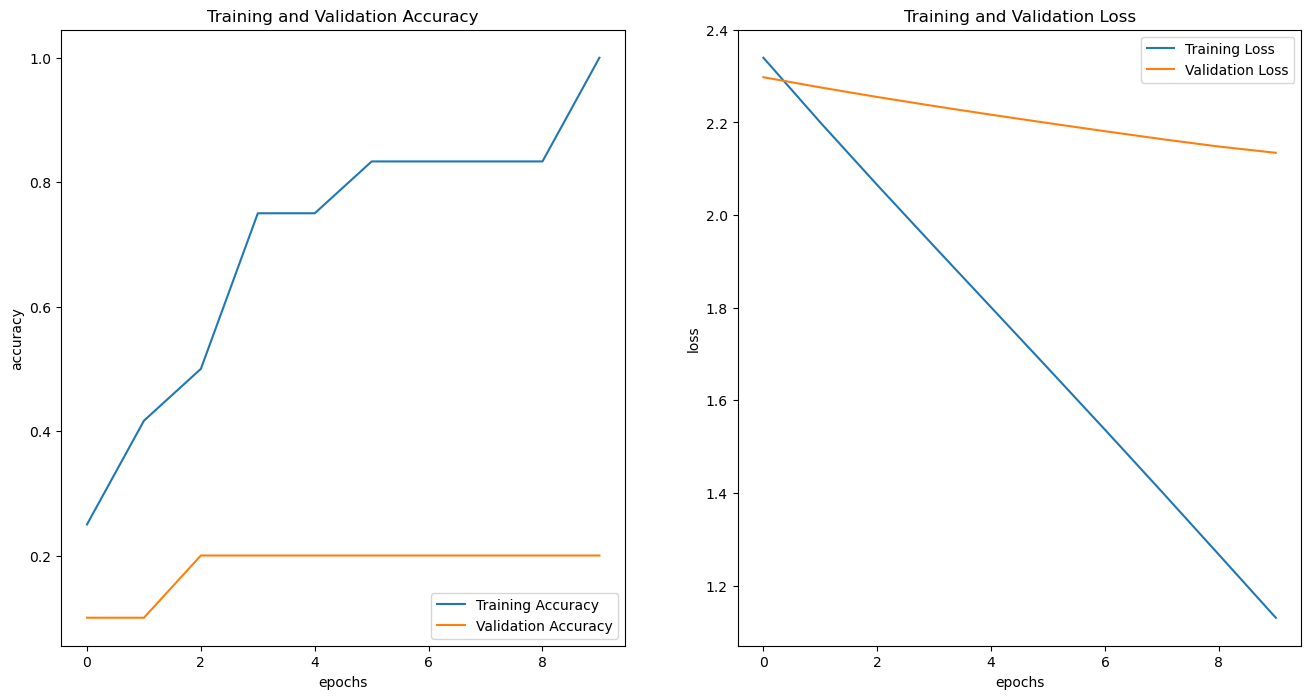

In [52]:
# Learning curves 

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss=history1.history['loss']
val_loss=history1.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [53]:
def define_model2(vocab_size, max_length):
    model2 = Sequential()
    model2.add(Embedding(vocab_size,300, input_length=max_length))
    model2.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
    model2.add(MaxPooling1D(pool_size = 4))
    model2.add(Flatten())
    model2.add(Dense(32, activation='relu'))
    model2.add(Dense(10, activation='softmax'))
    
    model2.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    
    # summarize defined model
    model2.summary()
    return model2

In [54]:
model1 = define_model2(vocab_size, max_length)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 300)           19800     
                                                                 
 conv1d (Conv1D)             (None, 9, 32)             19232     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 32)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                      

In [55]:
history = model1.fit(X_train, y_train, epochs=15, verbose=1,validation_data=(X_test,y_test),callbacks=callbacks)

Epoch 1/15
1/1 [==============================] - ETA: 0s - loss: 2.3150 - accuracy: 0.0000e+00
Epoch 1: val_loss did not improve from 2.13440
1/1 [==============================] - 3s 3s/step - loss: 2.3150 - accuracy: 0.0000e+00 - val_loss: 2.3056 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/15
1/1 [==============================] - ETA: 0s - loss: 2.2770 - accuracy: 0.3333
Epoch 2: val_loss did not improve from 2.13440
1/1 [==============================] - 0s 35ms/step - loss: 2.2770 - accuracy: 0.3333 - val_loss: 2.3027 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 3/15
1/1 [==============================] - ETA: 0s - loss: 2.2518 - accuracy: 0.7500
Epoch 3: val_loss did not improve from 2.13440
1/1 [==============================] - 0s 33ms/step - loss: 2.2518 - accuracy: 0.7500 - val_loss: 2.3002 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 4/15
1/1 [==============================] - ETA: 0s - loss: 2.2284 - accuracy: 0.7500
Epoch 4: val_loss did not improve from 2.13440
1/1 [==========

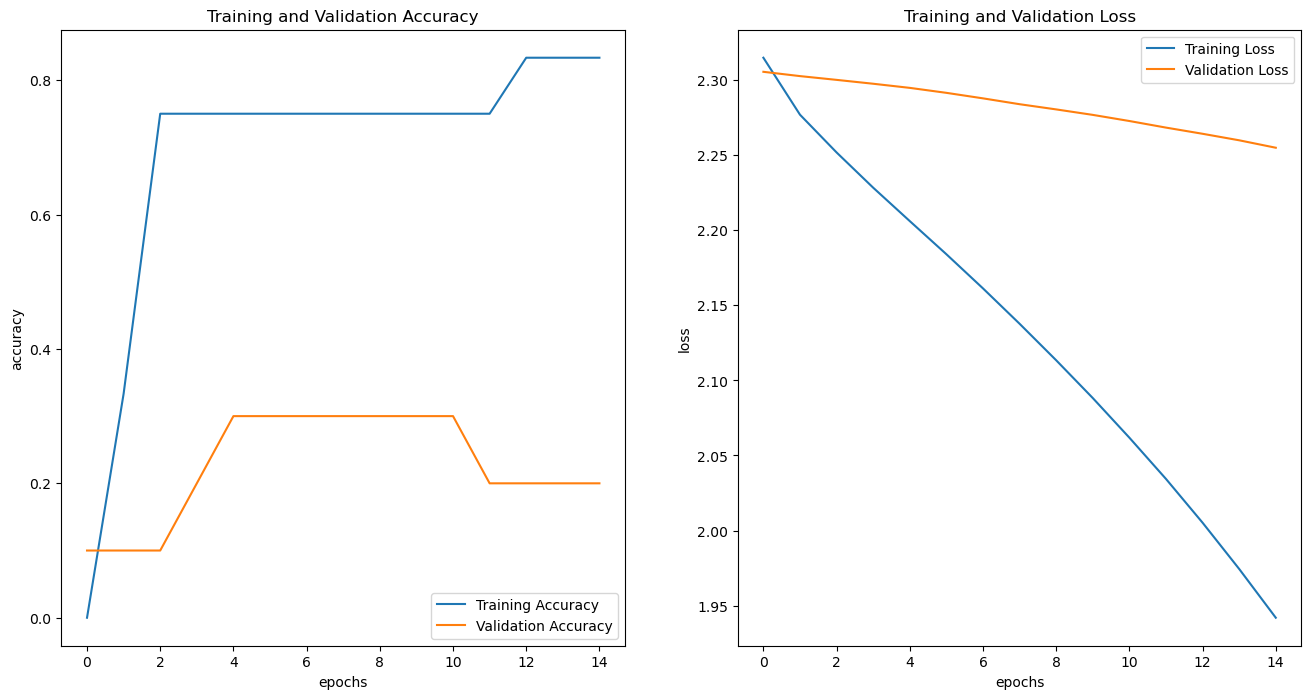

In [56]:
# Learning curves 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [57]:
def define_model3(vocab_size, max_length):
    model3 = Sequential()
    model3.add(Embedding(vocab_size,300, input_length=max_length))
    model3.add(LSTM(500))
    model3.add(Dense(10, activation='softmax'))
    
    model3.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    
    # summarize defined model
    model3.summary()
    return model3

In [58]:
model2 = define_model3(vocab_size, max_length)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 10, 300)           19800     
                                                                 
 lstm (LSTM)                 (None, 500)               1602000   
                                                                 
 dense_3 (Dense)             (None, 10)                5010      
                                                                 
Total params: 1,626,810
Trainable params: 1,626,810
Non-trainable params: 0
_________________________________________________________________


In [59]:
history = model2.fit(X_train, y_train, epochs=15, verbose=1,validation_data=(X_test,y_test))

Epoch 1/15
1/1 [==============================] - 3s 3s/step - loss: 2.3071 - accuracy: 0.0833 - val_loss: 2.2926 - val_accuracy: 0.2000
Epoch 2/15
1/1 [==============================] - 0s 35ms/step - loss: 2.2506 - accuracy: 0.2500 - val_loss: 2.2863 - val_accuracy: 0.1000
Epoch 3/15
1/1 [==============================] - 0s 33ms/step - loss: 2.1923 - accuracy: 0.4167 - val_loss: 2.2834 - val_accuracy: 0.1000
Epoch 4/15
1/1 [==============================] - 0s 33ms/step - loss: 2.1250 - accuracy: 0.4167 - val_loss: 2.2889 - val_accuracy: 0.1000
Epoch 5/15
1/1 [==============================] - 0s 35ms/step - loss: 2.0437 - accuracy: 0.4167 - val_loss: 2.3161 - val_accuracy: 0.1000
Epoch 6/15
1/1 [==============================] - 0s 33ms/step - loss: 1.9493 - accuracy: 0.4167 - val_loss: 2.3851 - val_accuracy: 0.1000
Epoch 7/15
1/1 [==============================] - 0s 51ms/step - loss: 1.8546 - accuracy: 0.4167 - val_loss: 2.4594 - val_accuracy: 0.1000
Epoch 8/15
1/1 [=============

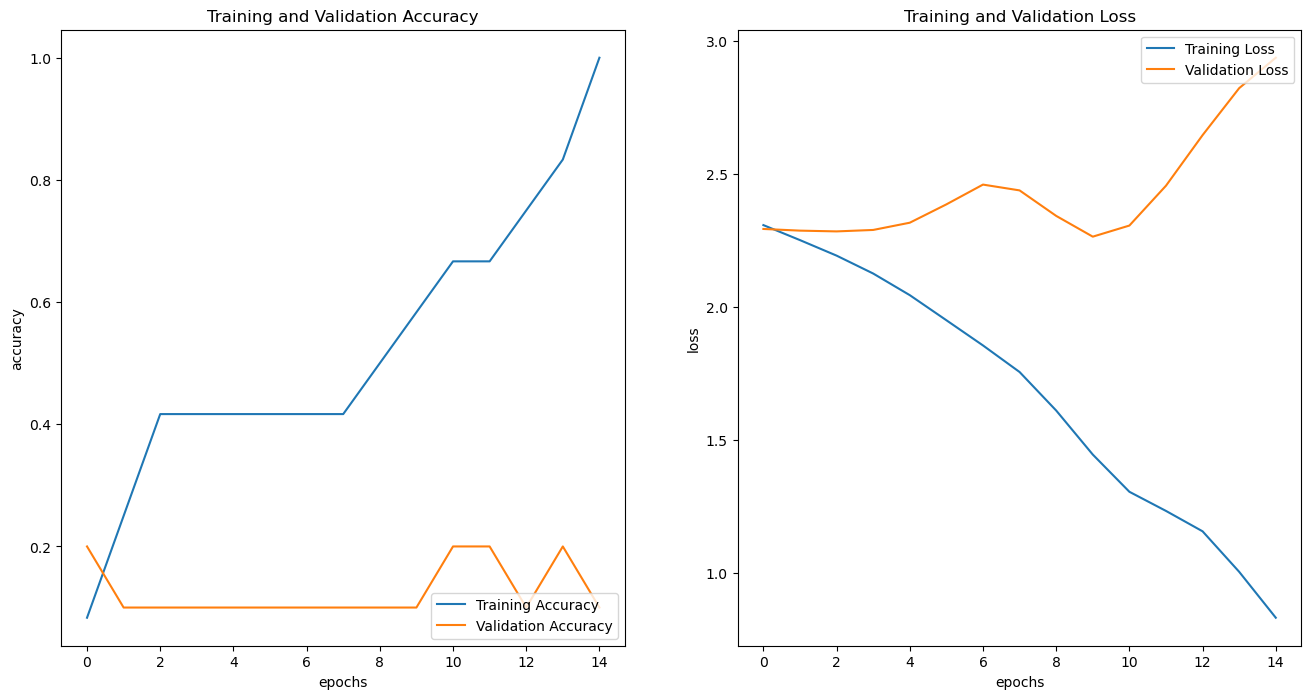

In [60]:
# Learning curves 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [61]:
def define_model3(vocab_size, max_length):
    model3 = Sequential()
    model3.add(Embedding(vocab_size,300, input_length=max_length))
    model3.add(GRU(500))
    model3.add(Dense(10, activation='softmax'))
    
    model3.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    
    # summarize defined model
    model3.summary()
    return model3

In [62]:
model3 = define_model3(vocab_size, max_length)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 10, 300)           19800     
                                                                 
 gru (GRU)                   (None, 500)               1203000   
                                                                 
 dense_4 (Dense)             (None, 10)                5010      
                                                                 
Total params: 1,227,810
Trainable params: 1,227,810
Non-trainable params: 0
_________________________________________________________________


In [63]:
history = model3.fit(X_train, y_train, epochs=15, verbose=1,validation_data=(X_test,y_test))


Epoch 1/15
1/1 [==============================] - 3s 3s/step - loss: 2.2971 - accuracy: 0.0833 - val_loss: 2.2941 - val_accuracy: 0.1000
Epoch 2/15
1/1 [==============================] - 0s 49ms/step - loss: 2.2283 - accuracy: 0.3333 - val_loss: 2.2945 - val_accuracy: 0.1000
Epoch 3/15
1/1 [==============================] - 0s 35ms/step - loss: 2.1604 - accuracy: 0.4167 - val_loss: 2.3033 - val_accuracy: 0.1000
Epoch 4/15
1/1 [==============================] - 0s 33ms/step - loss: 2.0885 - accuracy: 0.4167 - val_loss: 2.3268 - val_accuracy: 0.1000
Epoch 5/15
1/1 [==============================] - 0s 32ms/step - loss: 2.0112 - accuracy: 0.4167 - val_loss: 2.3745 - val_accuracy: 0.1000
Epoch 6/15
1/1 [==============================] - 0s 32ms/step - loss: 1.9310 - accuracy: 0.4167 - val_loss: 2.4475 - val_accuracy: 0.2000
Epoch 7/15
1/1 [==============================] - 0s 33ms/step - loss: 1.8493 - accuracy: 0.4167 - val_loss: 2.5083 - val_accuracy: 0.0000e+00
Epoch 8/15
1/1 [=========

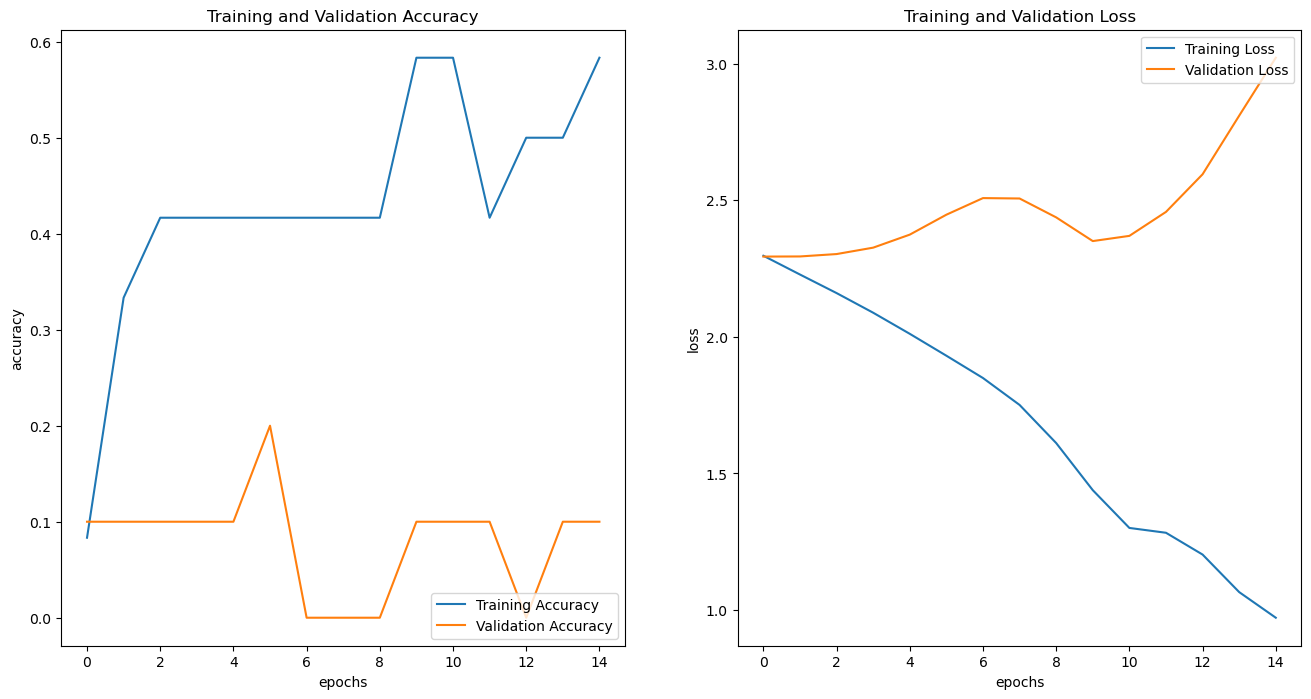

In [64]:
# Learning curves 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [65]:
def define_model3(vocab_size, max_length):
    model3 = Sequential()
    model3.add(Embedding(vocab_size,300, input_length=max_length))
    model3.add(Bidirectional(LSTM(500)))
    model3.add(Dense(10, activation='softmax'))
    
    model3.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    
    # summarize defined model
    model3.summary()
    return model3

In [66]:
model4 = define_model3(vocab_size, max_length)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 10, 300)           19800     
                                                                 
 bidirectional (Bidirectiona  (None, 1000)             3204000   
 l)                                                              
                                                                 
 dense_5 (Dense)             (None, 10)                10010     
                                                                 
Total params: 3,233,810
Trainable params: 3,233,810
Non-trainable params: 0
_________________________________________________________________


In [67]:
history = model4.fit(X_train, y_train, epochs=10, verbose=1,validation_data=(X_test,y_test))

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 2.3022 - accuracy: 0.1667 - val_loss: 2.2921 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 42ms/step - loss: 2.2317 - accuracy: 0.4167 - val_loss: 2.2836 - val_accuracy: 0.1000
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 2.1567 - accuracy: 0.5000 - val_loss: 2.2809 - val_accuracy: 0.1000
Epoch 4/10
1/1 [==============================] - 0s 36ms/step - loss: 2.0676 - accuracy: 0.3333 - val_loss: 2.2991 - val_accuracy: 0.1000
Epoch 5/10
1/1 [==============================] - 0s 35ms/step - loss: 1.9611 - accuracy: 0.3333 - val_loss: 2.3839 - val_accuracy: 0.1000
Epoch 6/10
1/1 [==============================] - 0s 36ms/step - loss: 1.8576 - accuracy: 0.4167 - val_loss: 2.5106 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 37ms/step - loss: 1.7658 - accuracy: 0.4167 - val_loss: 2.4930 - val_accuracy: 0.1000
Epoch 8/10
1/1 [=====

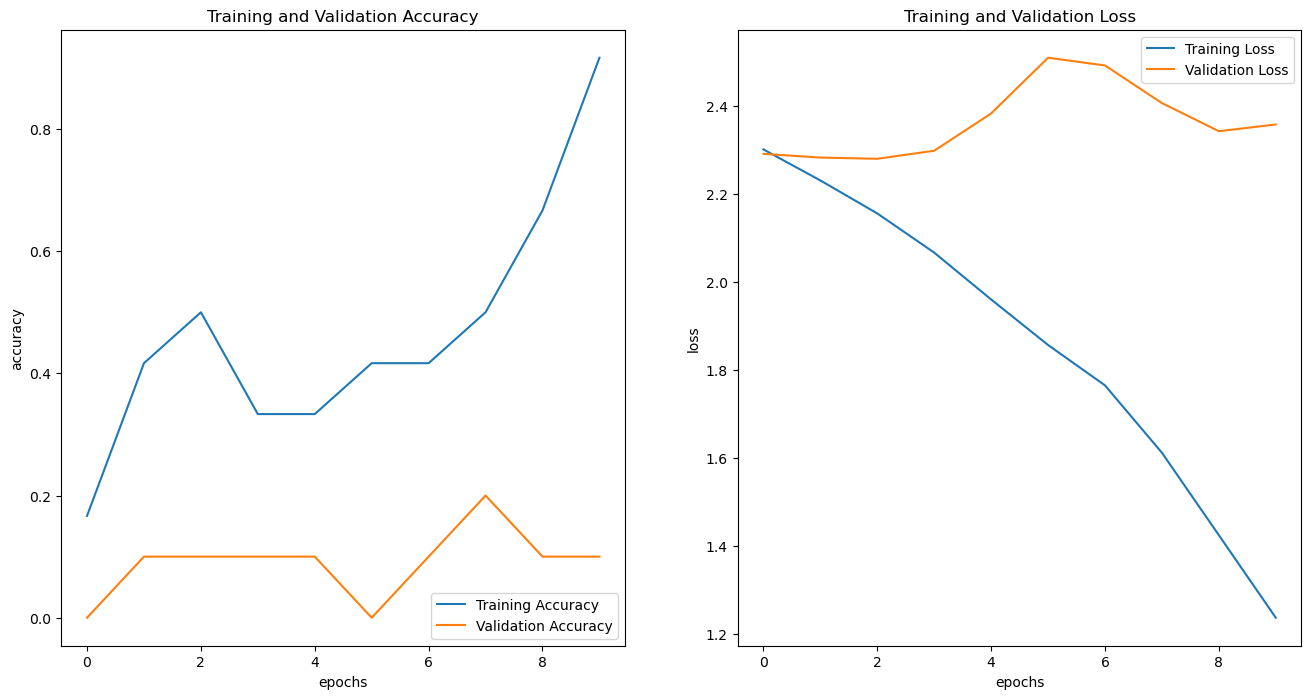

In [68]:
# Learning curves 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [69]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [70]:
def get_text(str_text):
    # print(str_text)
    input_text  = [str_text]
    df_input = pd.DataFrame(input_text,columns=['questions'])
    df_input
    return df_input

In [71]:
from tensorflow.keras.models import load_model
model = model2
tokenizer_t = joblib.load('tokenizer_t.pkl')
vocab = joblib.load('vocab.pkl')

In [72]:
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmantizer.lemmatize(w.lower()) for w in tokens]
    # stop_words = set(stopwords.words('english'))
    # tokens = [w for w in tokens if not w in stop_words]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens
     

def remove_stop_words_for_input(tokenizer,df,feature):
    doc_without_stopwords = []
    entry = df[feature][0]
    tokens = tokenizer(entry)
    doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return df
     

def encode_input_text(tokenizer_t,df,feature):
    t = tokenizer_t
    entry = entry = [df[feature][0]]
    encoded = t.texts_to_sequences(entry)
    padded = pad_sequences(encoded, maxlen=10, padding='post')
    return padded
     

def get_pred(model,encoded_input):
    pred = np.argmax(model.predict(encoded_input))
    return pred
     

def bot_precausion(df_input,pred):
    words = df_input.questions[0].split()
    if len([w for w in words if w in vocab])==0 :
        pred = 1
    return pred
     

def get_response(df2,pred):
    upper_bound = df2.groupby('labels').get_group(pred).shape[0]
    r = np.random.randint(0,upper_bound)
    responses = list(df2.groupby('labels').get_group(pred).response)
    return responses[r]
     

def bot_response(response,):
    print(response)

In [82]:
# correct response

df_input = get_text("What does it mean to have a mental illness")

# load artifacts 
tokenizer_t = joblib.load('tokenizer_t.pkl')
vocab = joblib.load('vocab.pkl')

df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
encoded_input = encode_input_text(tokenizer_t,df_input,'questions')

pred = get_pred(model,encoded_input)
pred = bot_precausion(df_input,pred)

response = get_response(df2,pred)
bot_response(response)
     

# wrong response

df_input = get_text("What treatment options are available?")

#load artifacts 
tokenizer_t = joblib.load('tokenizer_t.pkl')
vocab = joblib.load('vocab.pkl')

df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
encoded_input = encode_input_text(tokenizer_t,df_input,'questions')

pred = get_pred(model,encoded_input)
pred = bot_precausion(df_input,pred)

response = get_response(df2,pred)
bot_response(response)

1/1 [==============================] - 0s 18ms/step
Feeling comfortable with the professional you or your child is working with is critical to the success of your treatment. Finding the professional who best fits your needs may require some research.
1/1 [==============================] - 0s 18ms/step
Symptoms of mental health disorders vary depending on the type and severity of the condition.


In [77]:
# correct response

df_input = get_text("What does it mean to have a mental illness")

# load artifacts 
tokenizer_t = joblib.load('tokenizer_t.pkl')
vocab = joblib.load('vocab.pkl')

df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
encoded_input = encode_input_text(tokenizer_t,df_input,'questions')

pred = get_pred(model1,encoded_input)
pred = bot_precausion(df_input,pred)

response = get_response(df2,pred)
bot_response(response)
     

# wrong response

df_input = get_text("What treatment options are available?")

#load artifacts 
tokenizer_t = joblib.load('tokenizer_t.pkl')
vocab = joblib.load('vocab.pkl')

df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
encoded_input = encode_input_text(tokenizer_t,df_input,'questions')

pred = get_pred(model1,encoded_input)
pred = bot_precausion(df_input,pred)

response = get_response(df2,pred)
bot_response(response)

1/1 [==============================] - 0s 18ms/step
When healing from mental illness, early identification and treatment are of vital importance. Based on the nature of the illness, there are a range of effective treatments available. For any type of treatment, it is essential that the person affected is proactive and fully engaged in their own recovery process. Many people with mental illnesses who are diagnosed and treated respond well, although some might experience a return of symptoms. Even in such cases, with careful monitoring and management of the disorder, it is still quite possible to live a fulfilled and productive life.
1/1 [==============================] - 0s 18ms/step
Feeling comfortable with the professional you or your child is working with is critical to the success of the treatment. Finding the professional who best fits your needs may require research. Start by searching for providers in your area.


In [78]:
# correct response

df_input = get_text("What does it mean to have a mental illness")

# load artifacts 
tokenizer_t = joblib.load('tokenizer_t.pkl')
vocab = joblib.load('vocab.pkl')

df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
encoded_input = encode_input_text(tokenizer_t,df_input,'questions')

pred = get_pred(model2,encoded_input)
pred = bot_precausion(df_input,pred)

response = get_response(df2,pred)
bot_response(response)
     

# wrong response

df_input = get_text("What treatment options are available?")

#load artifacts 
tokenizer_t = joblib.load('tokenizer_t.pkl')
vocab = joblib.load('vocab.pkl')

df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
encoded_input = encode_input_text(tokenizer_t,df_input,'questions')

pred = get_pred(model2,encoded_input)
pred = bot_precausion(df_input,pred)

response = get_response(df2,pred)
bot_response(response)

1/1 [==============================] - 0s 348ms/step
Feeling comfortable with the professional you or your child is working with is critical to the success of your treatment. Finding the professional who best fits your needs may require some research.
1/1 [==============================] - 0s 22ms/step
Symptoms of mental health disorders vary depending on the type and severity of the condition.


In [79]:
# correct response

df_input = get_text("What does it mean to have a mental illness")

# load artifacts 
tokenizer_t = joblib.load('tokenizer_t.pkl')
vocab = joblib.load('vocab.pkl')

df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
encoded_input = encode_input_text(tokenizer_t,df_input,'questions')

pred = get_pred(model3,encoded_input)
pred = bot_precausion(df_input,pred)

response = get_response(df2,pred)
bot_response(response)
     

# wrong response

df_input = get_text("What treatment options are available?")

#load artifacts 
tokenizer_t = joblib.load('tokenizer_t.pkl')
vocab = joblib.load('vocab.pkl')

df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
encoded_input = encode_input_text(tokenizer_t,df_input,'questions')

pred = get_pred(model3,encoded_input)
pred = bot_precausion(df_input,pred)

response = get_response(df2,pred)
bot_response(response)

1/1 [==============================] - 0s 297ms/step
Feeling comfortable with the professional you or your child is working with is critical to the success of the treatment. Finding the professional who best fits your needs may require research. Start by searching for providers in your area.
1/1 [==============================] - 0s 21ms/step
Mental illnesses are health conditions that disrupt a person's thoughts, emotions, relationships, and daily functioning.


In [80]:
# correct response

df_input = get_text("What does it mean to have a mental illness")

# load artifacts 
tokenizer_t = joblib.load('tokenizer_t.pkl')
vocab = joblib.load('vocab.pkl')

df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
encoded_input = encode_input_text(tokenizer_t,df_input,'questions')

pred = get_pred(model4,encoded_input)
pred = bot_precausion(df_input,pred)

response = get_response(df2,pred)
bot_response(response)
     

# wrong response

df_input = get_text("What treatment options are available?")

#load artifacts 
tokenizer_t = joblib.load('tokenizer_t.pkl')
vocab = joblib.load('vocab.pkl')

df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
encoded_input = encode_input_text(tokenizer_t,df_input,'questions')

pred = get_pred(model4,encoded_input)
pred = bot_precausion(df_input,pred)

response = get_response(df2,pred)
bot_response(response)

1/1 [==============================] - 1s 635ms/step
When healing from mental illness, early identification and treatment are of vital importance. Based on the nature of the illness, there are a range of effective treatments available. For any type of treatment, it is essential that the person affected is proactive and fully engaged in their own recovery process. Many people with mental illnesses who are diagnosed and treated respond well, although some might experience a return of symptoms. Even in such cases, with careful monitoring and management of the disorder, it is still quite possible to live a fulfilled and productive life.
1/1 [==============================] - 0s 19ms/step
Symptoms of mental health disorders vary depending on the type and severity of the condition.
